In [1]:
library(naturalsort)
library(fields)
library(viridis)

dataDir <- '~/jackgl/data/simulations/0519/lusc_0520_4/'
ctype <- 'LUSC'

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-2 (2019-03-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 
Loading required package: viridisLite
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
flst <- naturalsort(list.files(dataDir))
flst <- flst[2:(length(flst))]

In [3]:
nd_het <- rep(NA,length(flst))
nd_hom <- rep(NA,length(flst))
np_het <- rep(NA,length(flst))
np_hom <- rep(NA,length(flst))
Ns <- array(NA,dim=c(length(flst),5e3))
mus <- rep(NA,length(flst))
N0s <- rep(NA,length(flst))

for (ii in 1:length(flst)) {
    load(paste0(dataDir,flst[ii]))
    N[N==0] <- NA
    Ns[ii,] <- N
    nd_het[ii] <- sum(Pop$nd_het[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    nd_hom[ii] <- sum(Pop$nd_hom[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    np_het[ii] <- sum(Pop$np_het[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    np_hom[ii] <- sum(Pop$np_hom[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    mus[ii] <- mu
    N0s[ii] <- N0
    rm(Pop,gen_time,N,mut_genes)
}

In [4]:
get_fc <- function(N) {
    return(N[length(which(!is.na(N)))]/N[1])
}

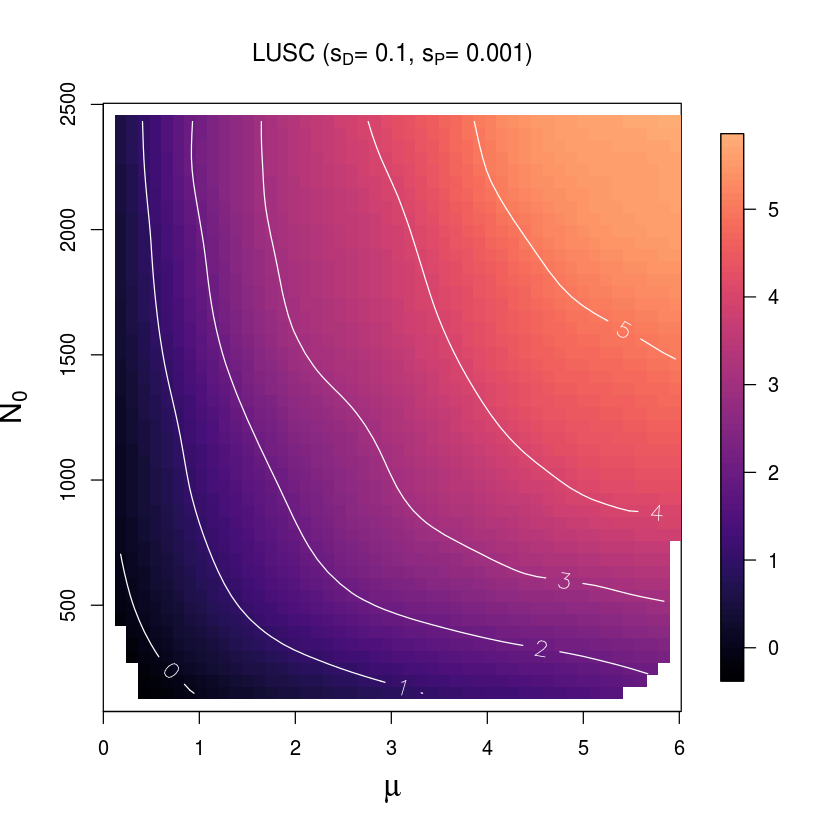

In [5]:
# Assign data to temporary objects
x <- mus
y <- N0s
# z <- as.vector(apply(Ns,1,get_fc))
z <- nd_hom

quant <- function(x) {quantile(x,0.9)}
closest <- function(x,v) {
    return(which.min(abs(v - x)))
}

cor <- data.frame(x=x,y=y,z=z)
test <- aggregate(cor, by=list(x,y), FUN=quant)
test$x <- test$Group.1
test$y <- test$Group.2
test <- test[test$y>=100,]

# Thin plate spline interpolation to irregular data
test.spline <- Tps(data.frame(test$x,test$y), test$z)#,lambda=0.01)

new.grid <- predictSurface(test.spline, nx = 50, ny = 50)
# v=quantile(seq(0,.3,0.01),seq(0.01,1,.01),na.rm=TRUE) # for standard dev.
# v=quantile(seq(0.6,1.5,0.01),seq(0.01,1,.01),na.rm=TRUE) # for fold change
v=quantile(seq(0,7,0.01),seq(0.01,1,.01),na.rm=TRUE) # for insertion count

cols <- magma(100)
image.plot(new.grid,
          col=cols[closest(min(new.grid$z[!is.na(new.grid$z)]),v):closest(max(new.grid$z[!is.na(new.grid$z)]),v)],
          xlab=expression(mu),
          ylab=expression(N[0]),
          cex.lab=1.5,
          main=bquote(paste(.(ctype),' (',s[D],'= 0.1, ',s[P],'= 0.001)')))
contour(new.grid,add=TRUE,nlevels=5,col='white',labcex=1.2)

# points(test$x,test$y,
#        col=cols[as.numeric(lapply(test$z,closest,v))],
#        pch=20,
#        cex=3)
# points(test$x,test$y,pch=1,col='beige')

# z <- as.vector(apply(Ns,1,get_fc))
# # z <- np_het
# cor <- data.frame(x=x,y=y,z=z)
# test <- aggregate(cor, by=list(x,y), FUN=quant)
# test$x <- test$Group.1
# test$y <- test$Group.2
# test <- test[test$y>=100,]
# # Thin plate spline interpolation to irregular data
# test.spline <- Tps(data.frame(test$x,test$y), test$z,lambda=0.01)
# new.grid <- predictSurface(test.spline, nx = 50, ny = 50)
# contour(new.grid,add=TRUE,nlevels=5,lty=1,col='white',labcex=1.5)